Initial hyperparameters:

Let's take `ReacherBulletEnv-v0` hyperparameters (https://github.com/araffin/rl-baselines-zoo/blob/master/hyperparams/ppo2.yml#L229) and adapt them:

```
n_envs: 8 -> 32
n_timesteps: 1e6 -> 250e3
policy: 'MlpPolicy'
n_steps: 2048 -> 128
nminibatches: 32 -> auto
lam: 0.95
gamma: 0.99 -> 0.90
noptepochs: 10 -> 30
ent_coef: 0.0 -> 0.01
learning_rate: 2.5e-4 -> 10e-4
cliprange: 0.2
```

In [1]:
from stable_baselines.bench.monitor import load_results
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import getmtime
from time import ctime

def load_trainings_summary(trainings):
    """Load in pandas 10 learning log per training"""
    # Load each data frame
    data_frames = []
    for t, t_name in trainings:
        for n in range(1, 11):
            train_df = load_results("training_logs/" + t + "_" + str(n))
            train_df["run"] = train_df.apply(lambda _: n, axis=1)
            train_df["exp_name"] = train_df.apply(lambda _: t_name, axis=1)
            data_frames.append(train_df)

    # Concat data
    df = pd.concat(data_frames)

    # Timestep column
    df['timestep'] = df.apply(lambda row: row['index']*row['l'], axis=1)

    # mean environments
    df_grouped = df.groupby(['exp_name', 'run', 'index'], as_index=False).mean()
    return df_grouped

def load_training_times(trainings):
    # Get total time for each learning
    times = pd.DataFrame()
    for name, i in trainings:
        for n in range(1, 11):
            filename = 'trained_models/' + name + '_' + str(n) + '.zip'
            times = times.append({'t': pd.to_datetime(getmtime(filename), unit='s'), 'i': i}, ignore_index=True)

    # Calculate timediff
    times['dt'] = times['t']-times['t'].shift()
    times = times.drop(columns='t').dropna()
    times['dt'] = times['dt'] / np.timedelta64(1, 's')
    return times

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Matplotlib created a temporary config/cache directory at /.config/matplotlib because the default path (/tmp/matplotlib-q2_b55yw) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Observation vector

(500.0, 4000.0)

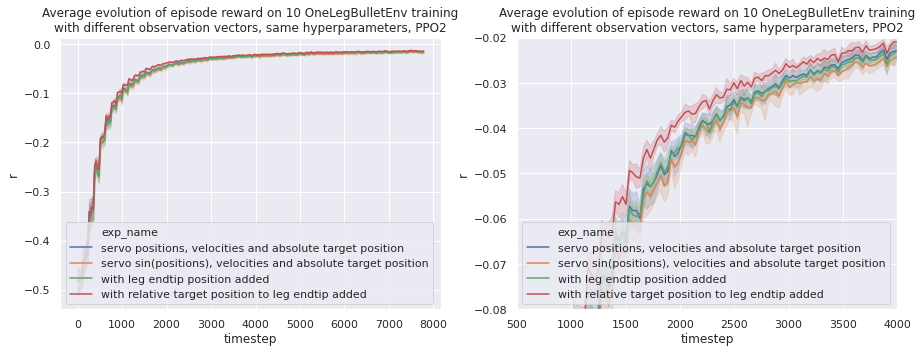

In [2]:
# Import learning summary
df_vec_obs = load_trainings_summary([
    ('vec_obs_position_velocity_target', 'servo positions, velocities and absolute target position'),
    ('vec_obs_position_velocity_endtip_position_target', 'with leg endtip position added'),
    ('vec_obs_position_velocity_endtip_to_target_position_target', 'with relative target position to leg endtip added'),
    ('vec_obs_sin_position_velocity_target', 'servo sin(positions), velocities and absolute target position'),
])

# Plot
sns.set()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different observation vectors, same hyperparameters, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_vec_obs)

plt.subplot(122)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different observation vectors, same hyperparameters, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_vec_obs)
plt.ylim((-0.08, -0.02))
plt.xlim((500, 4000))

Learning performances are similar for each observation vector.

We also observe that removing the leg end tip position does not penalize learning performance too much.

Zooming in, we can tell that the learning is a bit faster when giving the relative distance of the target to the end tip. But in practise this data requires to compute the direct mechanics of one robot leg, make it harder to transfer to the real robot later.

For all future training we will keep the following observation vector :
$$
obs = \begin{pmatrix} \theta_1 \\ \omega_1 \\ \theta_2 \\ \omega_2 \\ \theta_3 \\ \omega_3 \\ target_x \\ target_y \\ target_z \end{pmatrix}
$$
$\theta_i$ being the angle normalized between -1 (-90°) and 1 (90°) and $\omega_i$ the velocity normalized.

# n_envs

As PyBullet requires CPU and RAM, `n_envs` should be maximized until the RAM is fully used.

`n_envs=32` requires approximately 12 GiB of RAM.

# Batch size

As we are underutilisating the GPU, using the largest batch size possible should give better results with faster learning speed.

In [3]:
from gym_kraby.train import train

for batch_size in [32, 64, 128, 256, 512, 1024, 2048, 4096]:
    n_envs = 32  # opti
    n_steps = 128  # 4 simulation episodes per simulation

    if n_steps * n_envs < batch_size:
        nminibatches = 1  # limit batch_size to 32*128=4096
    else:
        nminibatches = int(n_steps * n_envs / batch_size)

    print("[+] Train hyperparam_batch_size_" + str(batch_size))
    """  # protection
    train(
        exp_name="hyperparam_batch_size_" + str(batch_size),
        env_name="gym_kraby:OneLegBulletEnv-v0",
        n_envs=n_envs,
        gamma=0.90,  # Discount factor
        n_steps=n_steps,  # batchsize = n_steps * n_envs
        ent_coef=0.01,  # Entropy coefficient for the loss calculation
        learning_rate=10e-4,
        lam=0.95,  # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        nminibatches=nminibatches,  # Number of training minibatches per update.
        noptepochs=30,  # Number of epoch when optimizing the surrogate
        cliprange=0.2,  # Clipping parameter, this clipping depends on the reward scaling
    )"""

[+] Train hyperparam_batch_size_32
[+] Train hyperparam_batch_size_64
[+] Train hyperparam_batch_size_128
[+] Train hyperparam_batch_size_256
[+] Train hyperparam_batch_size_512
[+] Train hyperparam_batch_size_1024
[+] Train hyperparam_batch_size_2048
[+] Train hyperparam_batch_size_4096


(500.0, 4000.0)

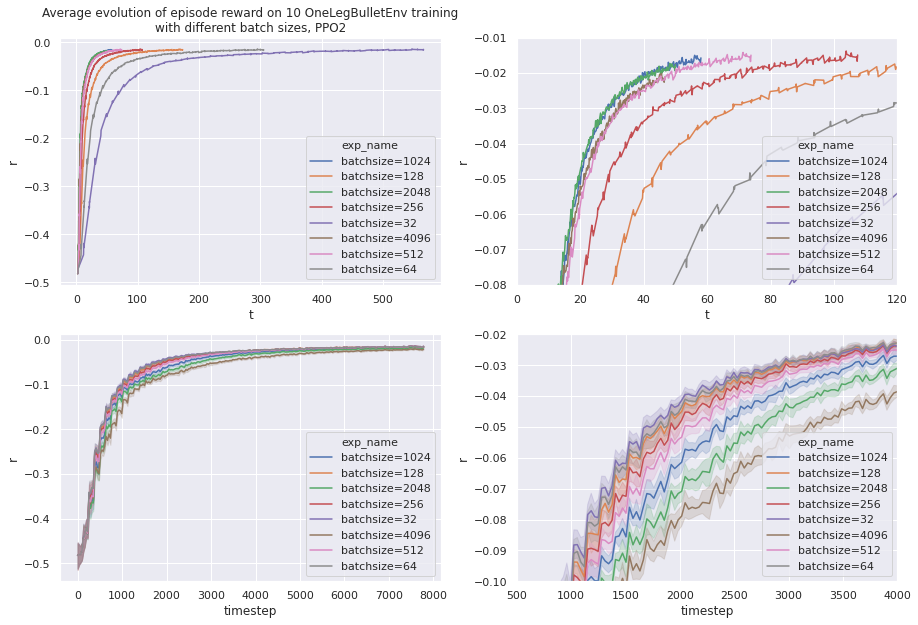

In [4]:
# Import learning summary
batchsizes = [32, 64, 128, 256, 512, 1024, 2048, 4096]
df_hyperparam_batch_size = load_trainings_summary([('hyperparam_batch_size_' + str(i), 'batchsize=' + str(i)) for i in batchsizes])

# Plot r(real time)
df_hyperparam_batch_size_mean = df_hyperparam_batch_size.groupby(['exp_name', 'index'], as_index=False).mean()
sns.set()
plt.figure(figsize=(15,10))

plt.subplot(221)
sns.lineplot(x="t", y="r", hue="exp_name", data=df_hyperparam_batch_size_mean)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different batch sizes, PPO2")

plt.subplot(222)
sns.lineplot(x="t", y="r", hue="exp_name", data=df_hyperparam_batch_size_mean)
plt.ylim((-0.08, -0.01))
plt.xlim((0,120))

# Plot r(t)
plt.subplot(223)
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_batch_size)

plt.subplot(224)
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_batch_size)
plt.ylim((-0.1, -0.02))
plt.xlim((500, 4000))

Text(0, 0.5, 'Learning time (s)')

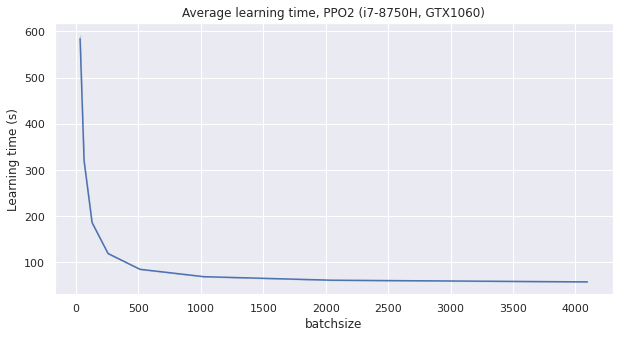

In [5]:
df_hyperparam_batch_size_dt = load_training_times([('hyperparam_batch_size_' + str(i), i) for i in batchsizes])
df_hyperparam_batch_size_dt = df_hyperparam_batch_size_dt.drop(index=40)  # absurd data

# Plot
sns.set()
plt.figure(figsize=(10,5))
plt.title("Average learning time, PPO2 (i7-8750H, GTX1060)")
sns.lineplot(x='i', y='dt', data=df_hyperparam_batch_size_dt)
plt.xlabel('batchsize')
plt.ylabel('Learning time (s)')

Lowering batch size makes the learning process converge faster, but at much lower speed.
It was expected because we are bottleneck by the data generation on CPU, a bigger batch size will make learning faster.

The learning rate needs to be adapted to a new batch size, this might be why the learning is more sample inefficient with larger batch size.

The conclusion of this experience is that we can keep `nminibatch=1` i.e. not splitting the generated data into smaller batch for the learning process. The batch size will be decided by the amount of environments multiplied by the numer of simulated steps in each environments.

# noptepochs

In [6]:
from gym_kraby.train import train

for noptepochs in [1, 5, 10, 20, 30, 50]:
    n_envs = 32  # opti
    n_steps = 128  # 4 simulation episodes per simulation
    nminibatches = 1  # opti

    print("[+] Train hyperparam_noptepochs_" + str(noptepochs))
    """  # protected
    train(
        exp_name="hyperparam_noptepochs_" + str(noptepochs),
        env_name="gym_kraby:OneLegBulletEnv-v0",
        n_envs=n_envs,
        gamma=0.90,  # Discount factor
        n_steps=n_steps,  # batchsize = n_steps * n_envs
        ent_coef=0.01,  # Entropy coefficient for the loss calculation
        learning_rate=10e-4,
        lam=0.95,  # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        nminibatches=nminibatches,  # Number of training minibatches per update.
        noptepochs=noptepochs,  # Number of epoch when optimizing the surrogate
        cliprange=0.2,  # Clipping parameter, this clipping depends on the reward scaling
    )
    """

[+] Train hyperparam_noptepochs_1
[+] Train hyperparam_noptepochs_5
[+] Train hyperparam_noptepochs_10
[+] Train hyperparam_noptepochs_20
[+] Train hyperparam_noptepochs_30
[+] Train hyperparam_noptepochs_50


<AxesSubplot:xlabel='t', ylabel='r'>

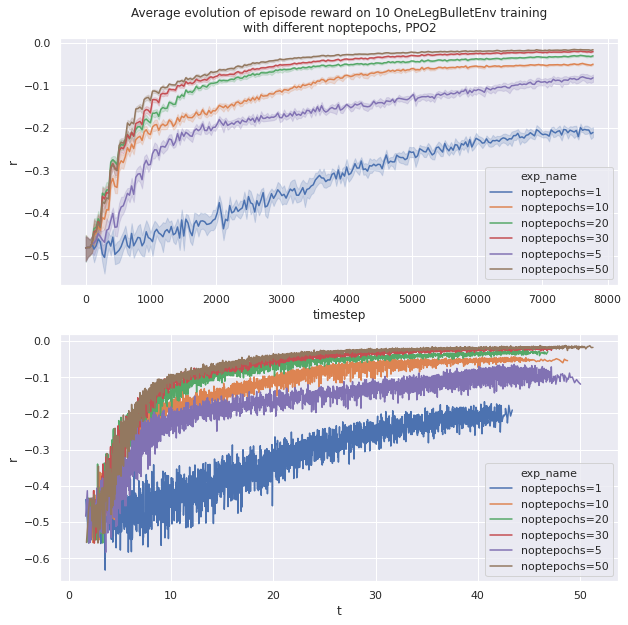

In [7]:
df_hyperparam_noptepochs = load_trainings_summary([('hyperparam_noptepochs_' + str(i), 'noptepochs=' + str(i)) for i in [1, 5, 10, 20, 30, 50]])

# Plot r(t)
sns.set()
plt.figure(figsize=(10,10))

plt.subplot(211)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different noptepochs, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_noptepochs)

plt.subplot(212)
sns.lineplot(x="t", y="r", hue="exp_name", data=df_hyperparam_noptepochs)

Text(0, 0.5, 'Learning time (s)')

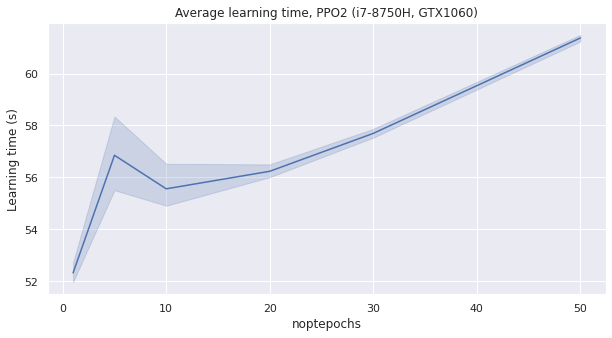

In [8]:
df_hyperparam_noptepochs_dt = load_training_times([('hyperparam_noptepochs_' + str(i), i) for i in [1, 5, 10, 20, 30, 50]])

# Plot
sns.set()
plt.figure(figsize=(10,5))
plt.title("Average learning time, PPO2 (i7-8750H, GTX1060)")
sns.lineplot(x='i', y='dt', data=df_hyperparam_noptepochs_dt)
plt.xlabel('noptepochs')
plt.ylabel('Learning time (s)')

`noptepochs` is the amount of learning episode with one batch of data. Increasing `noptepochs` will use more GPU and increase learning sample efficiency.
A good compromise seems to be `noptepochs=30`.

# n_steps

In [9]:
from gym_kraby.train import train

for n_steps in [32, 64, 128, 256, 512, 1024, 2048]:
    n_envs = 32  # opti
    nminibatches = 1  # opti
    noptepochs = 30  # opti

    print("[+] Train hyperparam_n_steps_" + str(n_steps))
    """ # protected
    train(
        exp_name="hyperparam_n_steps_" + str(n_steps),
        env_name="gym_kraby:OneLegBulletEnv-v0",
        n_envs=n_envs,
        gamma=0.90,  # Discount factor
        n_steps=n_steps,  # batchsize = n_steps * n_envs
        ent_coef=0.01,  # Entropy coefficient for the loss calculation
        learning_rate=10e-4,
        lam=0.95,  # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        nminibatches=nminibatches,  # Number of training minibatches per update.
        noptepochs=noptepochs,  # Number of epoch when optimizing the surrogate
        cliprange=0.2,  # Clipping parameter, this clipping depends on the reward scaling
    )
    """

[+] Train hyperparam_n_steps_32
[+] Train hyperparam_n_steps_64
[+] Train hyperparam_n_steps_128
[+] Train hyperparam_n_steps_256
[+] Train hyperparam_n_steps_512
[+] Train hyperparam_n_steps_1024
[+] Train hyperparam_n_steps_2048


<AxesSubplot:xlabel='t', ylabel='r'>

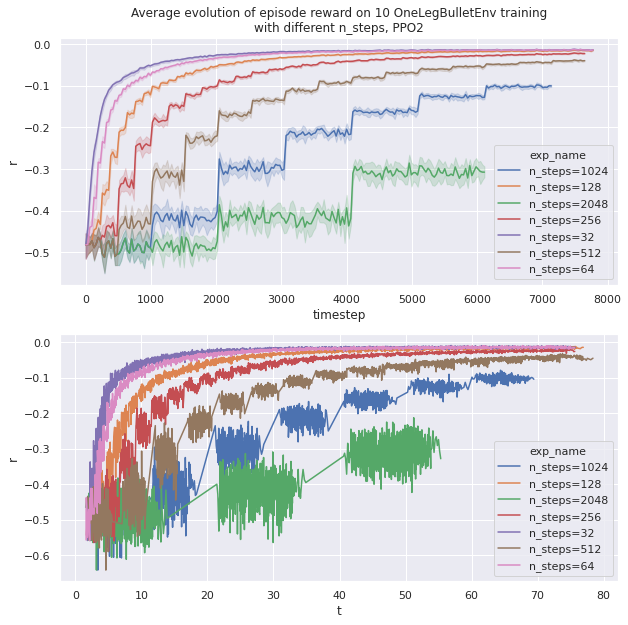

In [10]:
df_hyperparam_n_steps = load_trainings_summary([('hyperparam_n_steps_' + str(i), 'n_steps=' + str(i)) for i in [32, 64, 128, 256, 512, 1024, 2048]])

# Plot r(t)
sns.set()
plt.figure(figsize=(10,10))

plt.subplot(211)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different n_steps, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_n_steps)

plt.subplot(212)
sns.lineplot(x="t", y="r", hue="exp_name", data=df_hyperparam_n_steps)

The more `n_steps` grows, the more GPU time is needed. A too large batch size deteriorates performances. In fact one episode on 32 simulations seems plenty enough to have enough variance in the dataset.

When `n_steps` is larger, the total learning time is a bit faster as the timestep limit is 250k and it does not divide well with high power of 2. It is also a bit faster because less data transfer occurs

# Discount factor

In [11]:
from gym_kraby.train import train

for gamma in [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.98, 0.9999]:
    n_envs = 32  # opti
    nminibatches = 1  # opti
    noptepochs = 30  # opti
    n_steps = 32  # opti

    print("[+] Train hyperparam_gamma_" + str(gamma))
    """ # protected
    train(
        exp_name="hyperparam_gamma_" + str(gamma),
        env_name="gym_kraby:OneLegBulletEnv-v0",
        n_envs=n_envs,
        gamma=gamma,  # Discount factor
        n_steps=n_steps,  # batchsize = n_steps * n_envs
        ent_coef=0.01,  # Entropy coefficient for the loss calculation
        learning_rate=10e-4,
        lam=0.95,  # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        nminibatches=nminibatches,  # Number of training minibatches per update.
        noptepochs=noptepochs,  # Number of epoch when optimizing the surrogate
        cliprange=0.2,  # Clipping parameter, this clipping depends on the reward scaling
    )"""

[+] Train hyperparam_gamma_0.2
[+] Train hyperparam_gamma_0.4
[+] Train hyperparam_gamma_0.6
[+] Train hyperparam_gamma_0.8
[+] Train hyperparam_gamma_0.9
[+] Train hyperparam_gamma_0.95
[+] Train hyperparam_gamma_0.98
[+] Train hyperparam_gamma_0.9999


(500.0, 6000.0)

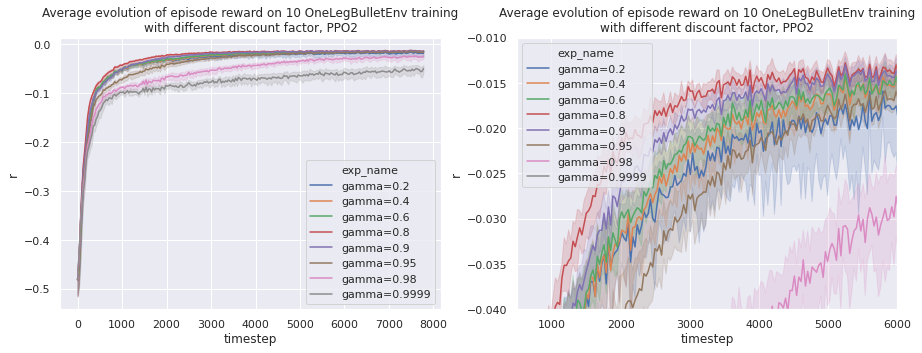

In [12]:
df_hyperparam_gamma = load_trainings_summary([('hyperparam_gamma_' + str(i), 'gamma=' + str(i)) for i in [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.98, 0.9999]])

# Plot r(t)
sns.set()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different discount factor, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_gamma)

plt.subplot(122)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different discount factor, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_gamma)
plt.ylim((-0.04, -0.01))
plt.xlim((500, 6000))

We observe that a discount factor between 0.8 and 0.9 gives best results. If the discount is too low or too high, then the repeatability of the learning decreases.

Actually we choose to use the distance between the target and the robot leg end as reward at every step. This leds to a negative return to maximize. Much better performances might be achievable using the derivative.

TODO test derivative

# cliprange

In [13]:
from gym_kraby.train import train

for cliprange in [0.1, 0.2, 0.3, 0.4]:
    n_envs = 32  # opti
    nminibatches = 1  # opti
    noptepochs = 30  # opti
    n_steps = 32  # opti
    gamma = 0.8  # opti

    print("[+] Train hyperparam_cliprange_" + str(cliprange))
    """  # protected
    train(
        exp_name="hyperparam_cliprange_" + str(cliprange),
        env_name="gym_kraby:OneLegBulletEnv-v0",
        n_envs=n_envs,
        gamma=gamma,  # Discount factor
        n_steps=n_steps,  # batchsize = n_steps * n_envs
        ent_coef=0.01,  # Entropy coefficient for the loss calculation
        learning_rate=10e-4,
        lam=0.95,  # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        nminibatches=nminibatches,  # Number of training minibatches per update.
        noptepochs=noptepochs,  # Number of epoch when optimizing the surrogate
        cliprange=cliprange,  # Clipping parameter, this clipping depends on the reward scaling
    )"""

[+] Train hyperparam_cliprange_0.1
[+] Train hyperparam_cliprange_0.2
[+] Train hyperparam_cliprange_0.3
[+] Train hyperparam_cliprange_0.4


(500.0, 6000.0)

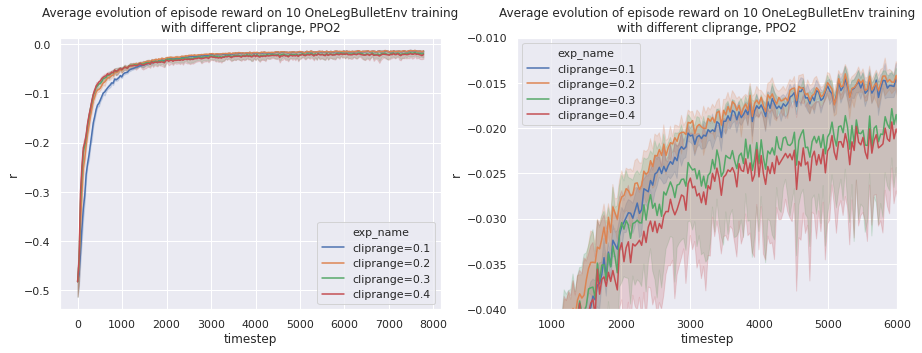

In [14]:
df_hyperparam_cliprange = load_trainings_summary([('hyperparam_cliprange_' + str(i), 'cliprange=' + str(i)) for i in [0.1, 0.2, 0.3, 0.4]])

# Plot r(t)
sns.set()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different cliprange, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_cliprange)

plt.subplot(122)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different cliprange, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_cliprange)
plt.ylim((-0.04, -0.01))
plt.xlim((500, 6000))

# learning_rate

In [15]:
from gym_kraby.train import train

for learning_rate in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
    n_envs = 32  # opti
    nminibatches = 1  # opti
    noptepochs = 30  # opti
    n_steps = 32  # opti
    gamma = 0.8  # opti
    cliprange = 0.2  # opti

    print("[+] Train hyperparam_learning_rate_" + str(learning_rate))
    """  # protected
    train(
        exp_name="hyperparam_learning_rate_" + str(learning_rate),
        env_name="gym_kraby:OneLegBulletEnv-v0",
        n_envs=n_envs,
        gamma=gamma,  # Discount factor
        n_steps=n_steps,  # batchsize = n_steps * n_envs
        ent_coef=0.01,  # Entropy coefficient for the loss calculation
        learning_rate=learning_rate,
        lam=0.95,  # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        nminibatches=nminibatches,  # Number of training minibatches per update.
        noptepochs=noptepochs,  # Number of epoch when optimizing the surrogate
        cliprange=cliprange,  # Clipping parameter, this clipping depends on the reward scaling
    )"""

[+] Train hyperparam_learning_rate_0.0001
[+] Train hyperparam_learning_rate_0.001
[+] Train hyperparam_learning_rate_0.01
[+] Train hyperparam_learning_rate_0.1
[+] Train hyperparam_learning_rate_1


(500.0, 6000.0)

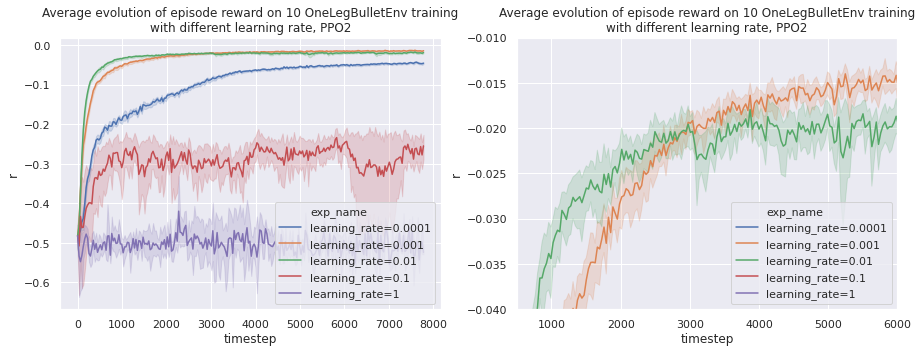

In [16]:
df_hyperparam_learning_rate = load_trainings_summary([('hyperparam_learning_rate_' + str(i), 'learning_rate=' + str(i)) for i in [1e-4, 1e-3, 1e-2, 1e-1, 1]])

# Plot r(t)
sns.set()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different learning rate, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_learning_rate)

plt.subplot(122)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different learning rate, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_learning_rate)
plt.ylim((-0.04, -0.01))
plt.xlim((500, 6000))

A learning rate of 0.01 gives the best sample efficiency but a smaller rate makes the learning converge closer to an optimal policy. One way to adress this would be to lower the learning rate during the training.

# lam

In [17]:
from gym_kraby.train import train

for lam in [0.8, 0.9, 0.92, 0.95, 0.98, 0.99, 1.0]:
    n_envs = 32  # opti
    nminibatches = 1  # opti
    noptepochs = 30  # opti
    n_steps = 32  # opti
    gamma = 0.8  # opti
    cliprange = 0.2  # opti
    learning_rate = 0.01  # opti

    print("[+] Train hyperparam_lam_" + str(lam))
    """  # protected
    train(
        exp_name="hyperparam_lam_" + str(lam),
        env_name="gym_kraby:OneLegBulletEnv-v0",
        n_envs=n_envs,
        gamma=gamma,  # Discount factor
        n_steps=n_steps,  # batchsize = n_steps * n_envs
        ent_coef=0.01,  # Entropy coefficient for the loss calculation
        learning_rate=learning_rate,
        lam=lam,  # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        nminibatches=nminibatches,  # Number of training minibatches per update.
        noptepochs=noptepochs,  # Number of epoch when optimizing the surrogate
        cliprange=cliprange,  # Clipping parameter, this clipping depends on the reward scaling
    )"""

[+] Train hyperparam_lam_0.8
[+] Train hyperparam_lam_0.9
[+] Train hyperparam_lam_0.92
[+] Train hyperparam_lam_0.95
[+] Train hyperparam_lam_0.98
[+] Train hyperparam_lam_0.99
[+] Train hyperparam_lam_1.0


(500.0, 6000.0)

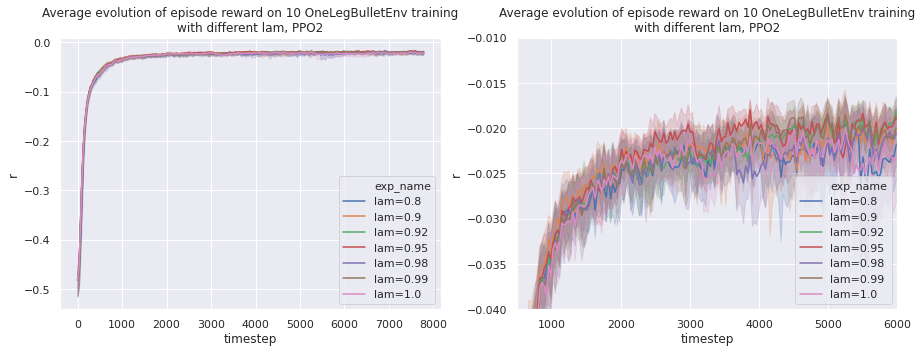

In [18]:
df_hyperparam_lam = load_trainings_summary([('hyperparam_lam_' + str(i), 'lam=' + str(i)) for i in [0.8, 0.9, 0.92, 0.95, 0.98, 0.99, 1.0]])

# Plot r(t)
sns.set()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different lam, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_lam)

plt.subplot(122)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different lam, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_lam)
plt.ylim((-0.04, -0.01))
plt.xlim((500, 6000))

# ent_coef

In [19]:
from gym_kraby.train import train

for ent_coef in [0.00000001, 0.000001, 0.0001, 0.01, 0.1]:
    n_envs = 32  # opti
    nminibatches = 1  # opti
    noptepochs = 30  # opti
    n_steps = 32  # opti
    gamma = 0.8  # opti
    cliprange = 0.2  # opti
    learning_rate = 0.01  # opti
    lam = 0.95  # opti

    print("[+] Train hyperparam_ent_coef_" + str(ent_coef))
    """ # protected
    train(
        exp_name="hyperparam_ent_coef_" + str(ent_coef),
        env_name="gym_kraby:OneLegBulletEnv-v0",
        n_envs=n_envs,
        gamma=gamma,  # Discount factor
        n_steps=n_steps,  # batchsize = n_steps * n_envs
        ent_coef=ent_coef,  # Entropy coefficient for the loss calculation
        learning_rate=learning_rate,
        lam=lam,  # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        nminibatches=nminibatches,  # Number of training minibatches per update.
        noptepochs=noptepochs,  # Number of epoch when optimizing the surrogate
        cliprange=cliprange,  # Clipping parameter, this clipping depends on the reward scaling
    )"""

[+] Train hyperparam_ent_coef_1e-08
[+] Train hyperparam_ent_coef_1e-06
[+] Train hyperparam_ent_coef_0.0001
[+] Train hyperparam_ent_coef_0.01
[+] Train hyperparam_ent_coef_0.1


(500.0, 6000.0)

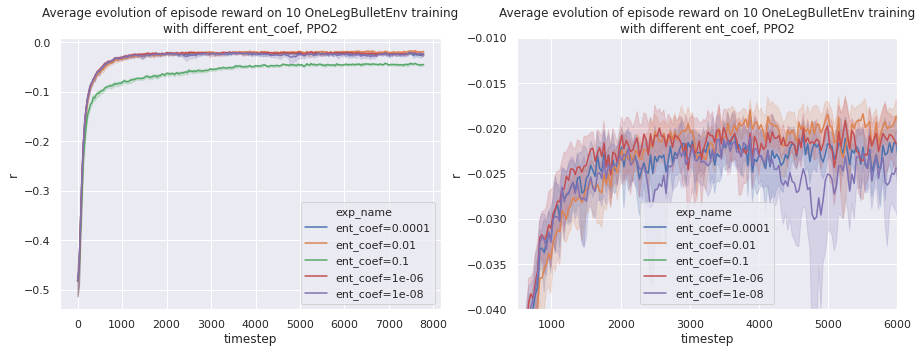

In [20]:
df_hyperparam_ent_coef = load_trainings_summary([('hyperparam_ent_coef_' + str(i), 'ent_coef=' + str(i)) for i in [0.00000001, 0.000001, 0.0001, 0.01, 0.1]])

# Plot r(t)
sns.set()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different ent_coef, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_ent_coef)

plt.subplot(122)
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training\nwith different ent_coef, PPO2")
sns.lineplot(x="timestep", y="r", hue="exp_name", data=df_hyperparam_ent_coef)
plt.ylim((-0.04, -0.01))
plt.xlim((500, 6000))